In [1]:
%cd ../..

/home/ireyes/Projects/pipeline/training/lc_classifier_ztf/ATAT_ALeRCE


/home/ireyes/anaconda3/envs/ATAT/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Confusion matrices

In [2]:
import os
import json 
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [4]:
path_data = './data/datasets/ZTF_ff/final/LC_MD_FEAT_240627_windows_200_12'
path_results = './results/ZTF_ff/LC_MD_FEAT/ireyes_test_7/MTA'
time_to_eval = 2048

order_classes = ['SNIa', # yes
                 'SNIbc', # yes
                 'SNIIb', # yes
                 'SNII', # yes
                 'SNIIn', # yes
                 'SLSN', # yes
                 'TDE', # yes
                 'Microlensing', # yes
                 'QSO', 
                 'AGN', # yes
                 'Blazar', 
                 'YSO', 
                 'CV/Nova', 
                 'LPV', 
                 'EA', 
                 'EB/EW', # yes
                 'Periodic-Other', 
                 'RSCVn', 
                 'CEP', 
                 'RRLab', 
                 'RRLc', 
                 'DSCT']

In [5]:
objects_partitions = pd.read_parquet('./data/datasets/ZTF_ff/partitions/240627/partitions.parquet')
obj_label = objects_partitions[objects_partitions['partition'] == 'test']
y_real_test = obj_label['alerceclass'].values
obj_label = ['aid_{}'.format(x) for x in obj_label['oid'].values]
obj_label

['aid_ZTF18adldhip',
 'aid_ZTF19aasbgeb',
 'aid_ZTF18aayfbqd',
 'aid_ZTF19ablyzbl',
 'aid_ZTF18actabfv',
 'aid_ZTF18aaztkvq',
 'aid_ZTF21aaphzsw',
 'aid_ZTF19aarhrcv',
 'aid_ZTF17aaajmxw',
 'aid_ZTF18acrvact',
 'aid_ZTF22aaahdyl',
 'aid_ZTF18aacebav',
 'aid_ZTF19abnqhwd',
 'aid_ZTF19abjgdow',
 'aid_ZTF18abklljv',
 'aid_ZTF18aalaphh',
 'aid_ZTF23aaaziou',
 'aid_ZTF17aacihzd',
 'aid_ZTF22abnmzar',
 'aid_ZTF17aaaoite',
 'aid_ZTF18abcurfb',
 'aid_ZTF18adbbyzu',
 'aid_ZTF18aaxpqts',
 'aid_ZTF18aacgwxk',
 'aid_ZTF18admcecv',
 'aid_ZTF18abukrnx',
 'aid_ZTF19aapuibt',
 'aid_ZTF18aawccep',
 'aid_ZTF21aahfpup',
 'aid_ZTF19aaoztzf',
 'aid_ZTF18aayijfg',
 'aid_ZTF18abgpcbj',
 'aid_ZTF18abwbiev',
 'aid_ZTF18actawil',
 'aid_ZTF20abyzomt',
 'aid_ZTF17aabxqbf',
 'aid_ZTF18abukymf',
 'aid_ZTF18abvbsoc',
 'aid_ZTF18actunfi',
 'aid_ZTF18aazfeau',
 'aid_ZTF22aaayewi',
 'aid_ZTF18aaxtcdl',
 'aid_ZTF18abtoxjw',
 'aid_ZTF18acdpxfb',
 'aid_ZTF18aabvmax',
 'aid_ZTF18abbogne',
 'aid_ZTF18aapnlus',
 'aid_ZTF18ab

In [6]:
y_real_test.shape

(8346,)

In [7]:
len(obj_label)

8346

In [8]:
import yaml

def load_yaml(path):
    with open(path, 'r') as file:
        args = yaml.load(file, Loader=yaml.FullLoader)
    return args

dict_info = load_yaml('{}/dict_info.yaml'.format(path_data))

mapping_classes = dict_info['mapping_classes']
mapping_classes_inverted = {v: k for k, v in mapping_classes.items()}
print(mapping_classes_inverted)

{0: 'AGN', 8: 'Blazar', 12: 'CEP', 5: 'CV/Nova', 15: 'DSCT', 2: 'EA', 10: 'EB/EW', 11: 'LPV', 21: 'Microlensing', 14: 'Periodic-Other', 1: 'QSO', 13: 'RRLab', 6: 'RRLc', 7: 'RSCVn', 17: 'SLSN', 9: 'SNII', 19: 'SNIIb', 20: 'SNIIn', 4: 'SNIa', 16: 'SNIbc', 18: 'TDE', 3: 'YSO'}


In [9]:
def sort_dict_by_value(d, reverse=False):
    return dict(sorted(d.items(), key=lambda x: x[1], reverse=reverse))

sort_classes = list(sort_dict_by_value(mapping_classes).keys())
print(sort_classes)

['AGN', 'QSO', 'EA', 'YSO', 'SNIa', 'CV/Nova', 'RRLc', 'RSCVn', 'Blazar', 'SNII', 'EB/EW', 'LPV', 'CEP', 'RRLab', 'Periodic-Other', 'DSCT', 'SNIbc', 'SLSN', 'TDE', 'SNIIb', 'SNIIn', 'Microlensing']


In [10]:
predictions = torch.load('{}/all_predictions_times.pt'.format(path_results))
predictions

{'SNID': array([b'ZTF17aaaecgi_0', b'ZTF17aaaecgi_1', b'ZTF17aaaecgi_2', ...,
        b'ZTF23abcvqkd_3', b'ZTF23abcvqkd_4', b'ZTF23abcvqkd_5'],
       dtype=object),
 'y_test': tensor([10, 10, 10,  ...,  4,  4,  4]),
 'list_y_pred': {'test_16': array([ 2, 10, 10, ...,  9,  9,  9]),
  'test_32': array([10, 10, 10, ..., 16,  9,  9]),
  'test_64': array([10, 10, 10, ..., 16, 16,  9]),
  'test_128': array([10, 10, 10, ..., 16, 16,  9]),
  'test_256': array([10, 10, 10, ...,  9, 16,  9]),
  'test_512': array([10, 10, 10, ...,  9,  9,  9]),
  'test_1024': array([10, 10, 10, ...,  9,  9,  9]),
  'test_2048': array([10, 10, 10, ...,  4,  4,  4])},
 'list_y_pred_prob': {'test_16': array([[3.10798711e-08, 9.77926295e-10, 6.66719139e-01, ...,
          2.40659895e-13, 1.65955596e-10, 1.63193244e-11],
         [4.91363856e-08, 9.43447653e-10, 4.34738308e-01, ...,
          1.00472385e-13, 7.36060449e-11, 6.45256288e-12],
         [5.20331085e-08, 1.17464460e-09, 3.07417154e-01, ...,
          3.97

In [11]:
# Procesamiento para agregar los índices correspondientes
from itertools import groupby

# Convertir bytes a str para facilitar la manipulación
snids_str = [snid.decode("utf-8") for snid in predictions['SNID']]

# Función para extraer el identificador base de cada SNID
def base_id(snid):
    return "_".join(snid.split("_")[:-1])

# Agrupar por el identificador base
grouped = groupby(range(len(snids_str)), key=lambda x: base_id(snids_str[x]))

# Crear la nueva clave con los índices agrupados
idx_windows_objects = [list(group) for _, group in grouped]

# Crear la clave 'idx_unique_y_test' con los índices del SNID 0 de todos los objetos
idx_unique_y_test = []
ids_unique_real = []

for i, snid in enumerate(snids_str):
    if snid.endswith("_0"):
        idx_unique_y_test.append(i)
        ids_unique_real.append('aid_{}'.format(snid.split('_')[0]))

# Mostrar el resultado
print('length: ', len(idx_windows_objects))
print('length: ', len(idx_unique_y_test))

length:  41728
length:  41728


In [12]:
print(ids_unique_real)
print(len(ids_unique_real))

['aid_ZTF17aaaecgi', 'aid_ZTF17aaaedvi', 'aid_ZTF17aaafglk', 'aid_ZTF17aaafiut', 'aid_ZTF17aaafiww', 'aid_ZTF17aaafyis', 'aid_ZTF17aaafyxs', 'aid_ZTF17aaagryq', 'aid_ZTF17aaaidzt', 'aid_ZTF17aaaizfv', 'aid_ZTF17aaakbvl', 'aid_ZTF17aaaorgv', 'aid_ZTF17aaaowhs', 'aid_ZTF17aaaqtul', 'aid_ZTF17aaarxab', 'aid_ZTF17aaarxbz', 'aid_ZTF17aaarzye', 'aid_ZTF17aaasboc', 'aid_ZTF17aaasklh', 'aid_ZTF17aaatgma', 'aid_ZTF17aaatkxt', 'aid_ZTF17aaatlhi', 'aid_ZTF17aaauijj', 'aid_ZTF17aaaweng', 'aid_ZTF17aaawqzp', 'aid_ZTF17aabhlnm', 'aid_ZTF17aabooqt', 'aid_ZTF17aabootn', 'aid_ZTF17aabopzp', 'aid_ZTF17aaboqfs', 'aid_ZTF17aabppsz', 'aid_ZTF17aabppwh', 'aid_ZTF17aabqidu', 'aid_ZTF17aabummz', 'aid_ZTF17aabupde', 'aid_ZTF17aabuphg', 'aid_ZTF17aabuuyx', 'aid_ZTF17aabuvjm', 'aid_ZTF17aabvgfc', 'aid_ZTF17aabviic', 'aid_ZTF17aabxamk', 'aid_ZTF17aabxkhe', 'aid_ZTF17aacgwpq', 'aid_ZTF17aackses', 'aid_ZTF17aactvce', 'aid_ZTF17aadgwyo', 'aid_ZTF17aadidmw', 'aid_ZTF17aadjkhd', 'aid_ZTF17aadooax', 'aid_ZTF18aaaajiw',

In [13]:
# Calcular el promedio de las probabilidades para cada conjunto de ventanas

predictions.update({
    'list_y_pred_prob_avg': dict(),
    'list_y_pred_avg': dict(),
    })

for eval_time, predicciones in predictions['list_y_pred_prob'].items():
    predictions['list_y_pred_prob_avg'][eval_time] = [] 
    predictions['list_y_pred_avg'][eval_time] = [] 
    for idx_windows in idx_windows_objects:
        window_probs = predicciones[idx_windows]
        avg_probs = np.mean(window_probs, axis=0)
        predictions['list_y_pred_prob_avg'][eval_time].append(avg_probs)
        predictions['list_y_pred_avg'][eval_time].append(np.argmax(avg_probs, axis=0))

    predictions['list_y_pred_prob_avg'][eval_time] = np.array(predictions['list_y_pred_prob_avg'][eval_time])
    predictions['list_y_pred_avg'][eval_time] = np.array(predictions['list_y_pred_avg'][eval_time])

predictions['list_y_pred_avg']

{'test_16': array([10, 11,  5, ...,  4,  4,  9]),
 'test_32': array([10, 11,  5, ...,  4,  4,  9]),
 'test_64': array([10, 11,  5, ..., 20,  4,  9]),
 'test_128': array([10, 11,  5, ..., 20,  4,  9]),
 'test_256': array([10, 11,  5, ..., 20,  4,  9]),
 'test_512': array([10, 11,  5, ..., 20,  4,  9]),
 'test_1024': array([10, 11,  5, ..., 20,  4,  9]),
 'test_2048': array([10, 11,  5, ..., 20,  4,  4])}

In [14]:
predictions['list_y_pred_avg']['test_2048'].shape

(41728,)

In [15]:
predictions.keys()

dict_keys(['SNID', 'y_test', 'list_y_pred', 'list_y_pred_prob', 'list_y_pred_prob_avg', 'list_y_pred_avg'])

In [16]:
predictions['y_test'].shape

torch.Size([252810])

In [17]:
predictions['SNID'].shape

(252810,)

In [18]:
print(idx_unique_y_test)

[0, 8, 16, 21, 30, 38, 46, 54, 57, 62, 67, 74, 80, 84, 96, 101, 106, 113, 119, 124, 128, 132, 139, 144, 155, 164, 168, 177, 189, 200, 209, 218, 227, 235, 245, 255, 263, 271, 279, 288, 295, 304, 310, 314, 319, 320, 325, 330, 334, 338, 341, 347, 354, 363, 370, 377, 384, 392, 395, 402, 408, 415, 422, 430, 438, 445, 453, 462, 472, 479, 488, 494, 500, 504, 511, 515, 530, 543, 548, 554, 561, 572, 585, 597, 610, 622, 635, 642, 654, 662, 671, 678, 693, 706, 713, 719, 724, 734, 742, 746, 756, 772, 781, 788, 794, 802, 811, 819, 826, 835, 843, 847, 859, 867, 879, 894, 898, 907, 915, 922, 930, 939, 946, 953, 961, 970, 979, 988, 997, 1009, 1012, 1019, 1031, 1040, 1051, 1059, 1066, 1074, 1081, 1090, 1097, 1101, 1109, 1117, 1128, 1133, 1140, 1152, 1163, 1170, 1181, 1184, 1192, 1199, 1207, 1211, 1221, 1234, 1241, 1251, 1260, 1267, 1277, 1281, 1289, 1295, 1304, 1310, 1318, 1324, 1328, 1332, 1338, 1350, 1356, 1361, 1368, 1375, 1384, 1392, 1398, 1405, 1413, 1418, 1426, 1434, 1446, 1453, 1459, 1465, 1473,

In [19]:
print(ids_unique_real)

['aid_ZTF17aaaecgi', 'aid_ZTF17aaaedvi', 'aid_ZTF17aaafglk', 'aid_ZTF17aaafiut', 'aid_ZTF17aaafiww', 'aid_ZTF17aaafyis', 'aid_ZTF17aaafyxs', 'aid_ZTF17aaagryq', 'aid_ZTF17aaaidzt', 'aid_ZTF17aaaizfv', 'aid_ZTF17aaakbvl', 'aid_ZTF17aaaorgv', 'aid_ZTF17aaaowhs', 'aid_ZTF17aaaqtul', 'aid_ZTF17aaarxab', 'aid_ZTF17aaarxbz', 'aid_ZTF17aaarzye', 'aid_ZTF17aaasboc', 'aid_ZTF17aaasklh', 'aid_ZTF17aaatgma', 'aid_ZTF17aaatkxt', 'aid_ZTF17aaatlhi', 'aid_ZTF17aaauijj', 'aid_ZTF17aaaweng', 'aid_ZTF17aaawqzp', 'aid_ZTF17aabhlnm', 'aid_ZTF17aabooqt', 'aid_ZTF17aabootn', 'aid_ZTF17aabopzp', 'aid_ZTF17aaboqfs', 'aid_ZTF17aabppsz', 'aid_ZTF17aabppwh', 'aid_ZTF17aabqidu', 'aid_ZTF17aabummz', 'aid_ZTF17aabupde', 'aid_ZTF17aabuphg', 'aid_ZTF17aabuuyx', 'aid_ZTF17aabuvjm', 'aid_ZTF17aabvgfc', 'aid_ZTF17aabviic', 'aid_ZTF17aabxamk', 'aid_ZTF17aabxkhe', 'aid_ZTF17aacgwpq', 'aid_ZTF17aackses', 'aid_ZTF17aactvce', 'aid_ZTF17aadgwyo', 'aid_ZTF17aadidmw', 'aid_ZTF17aadjkhd', 'aid_ZTF17aadooax', 'aid_ZTF18aaaajiw',

In [20]:
predictions['labels_final'] = predictions['y_test'][idx_unique_y_test]
predictions['ids_final'] = np.array(ids_unique_real)
print(predictions['labels_final'].shape)

df_atat_pred = []

for eval_time, prob_classes in predictions['list_y_pred_prob_avg'].items():
    df = pd.DataFrame(prob_classes, columns=sort_classes)
    df['shorten'] = str(eval_time.split('_')[-1])
    df.index = predictions['ids_final']
    df_atat_pred.append(df)

df_atat_pred = pd.concat(df_atat_pred)
df_atat_pred

torch.Size([41728])


,AGN,QSO,EA,YSO,SNIa,CV/Nova,RRLc,RSCVn,Blazar,SNII,...,RRLab,Periodic-Other,DSCT,SNIbc,SLSN,TDE,SNIIb,SNIIn,Microlensing,shorten
aid_ZTF17aaaecgi,8.734759e-08,1.407601e-09,2.705836e-01,3.345798e-03,5.370557e-08,0.000115,1.061276e-02,5.166276e-06,4.123581e-08,5.541094e-08,...,7.465251e-04,8.544342e-08,1.774296e-02,1.197233e-10,1.062761e-12,3.664195e-10,9.733188e-14,9.460005e-10,1.274848e-11,16
aid_ZTF17aaaedvi,1.395941e-07,1.308934e-09,2.133583e-06,1.702210e-03,9.016076e-09,0.000019,1.206806e-07,1.360398e-06,2.353499e-08,1.064553e-08,...,1.240696e-06,1.478997e-06,2.318487e-06,1.846779e-09,7.985744e-11,3.413673e-15,1.132434e-14,1.273071e-11,7.031770e-13,16
aid_ZTF17aaafglk,3.056342e-06,4.072757e-05,1.821813e-02,2.970178e-04,1.978512e-05,0.905396,2.057924e-03,1.030598e-02,6.650857e-04,9.648635e-06,...,4.563576e-03,1.757647e-02,3.163386e-03,3.280139e-05,3.922877e-11,3.831226e-07,8.830703e-06,2.697534e-08,6.710195e-10,16
aid_ZTF17aaafiut,4.026390e-08,1.432371e-08,7.677610e-01,2.010072e-05,2.685211e-07,0.000026,1.448140e-03,5.071882e-03,9.630448e-09,5.542032e-07,...,2.045172e-03,7.862778e-03,3.332013e-04,1.000665e-09,2.312153e-13,5.750874e-09,3.508439e-10,1.985661e-10,9.313254e-10,16
aid_ZTF17aaafiww,2.984908e-08,3.914010e-08,1.588708e-01,5.051553e-05,2.601572e-07,0.000728,2.108612e-02,2.492834e-02,6.615269e-08,8.534976e-08,...,5.351029e-02,5.957882e-02,2.909251e-02,1.900539e-08,5.943157e-13,2.931560e-09,6.628973e-12,3.339336e-09,2.140507e-10,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF23aamapva,4.181310e-09,1.263017e-08,2.118022e-04,6.018315e-07,5.342381e-07,0.000029,2.892455e-04,5.389011e-03,2.175925e-09,1.730630e-08,...,9.476592e-06,9.918454e-01,4.205109e-04,1.568124e-11,9.512014e-16,3.274003e-12,7.289479e-11,3.525165e-11,9.182544e-15,2048
aid_ZTF23aamsarj,5.385992e-07,1.198062e-07,6.480413e-10,5.330119e-09,5.889830e-01,0.000221,1.462704e-09,2.542274e-09,2.813249e-09,1.856505e-01,...,2.114202e-08,2.077348e-11,3.960844e-10,1.943815e-01,1.305569e-09,2.173053e-11,8.305863e-07,3.076299e-02,1.057365e-08,2048
aid_ZTF23aamxeoe,8.068393e-05,5.983785e-06,7.539505e-09,1.492593e-08,1.195626e-02,0.000263,4.567974e-08,8.425167e-09,3.112131e-06,6.306412e-03,...,5.999429e-08,5.794033e-08,3.406927e-09,3.346236e-03,4.006599e-06,1.348790e-02,8.883385e-13,9.645457e-01,7.997967e-12,2048
aid_ZTF23aavxvsz,1.091022e-05,5.176812e-09,1.669908e-07,2.023352e-05,9.989874e-01,0.000008,1.167655e-07,6.753847e-07,5.292416e-07,4.464981e-04,...,3.871229e-07,1.419517e-09,4.592388e-09,5.190494e-04,4.327620e-13,6.320568e-09,6.786933e-10,1.153693e-09,2.832600e-07,2048


In [39]:
atat_pred_2048_time_test = df_atat_pred[df_atat_pred['shorten'] == '2048']
atat_pred_2048_time_test = atat_pred_2048_time_test.reindex(obj_label)[sort_classes]
atat_pred_2048_time_test

,AGN,QSO,EA,YSO,SNIa,CV/Nova,RRLc,RSCVn,Blazar,SNII,...,CEP,RRLab,Periodic-Other,DSCT,SNIbc,SLSN,TDE,SNIIb,SNIIn,Microlensing
aid_ZTF18adldhip,7.662808e-01,2.302854e-01,2.135166e-06,8.777586e-06,3.968655e-05,1.624198e-06,0.000007,0.000051,3.216724e-03,5.469867e-06,...,3.527732e-07,1.925852e-07,9.147311e-05,1.255014e-07,2.337902e-10,5.576798e-08,5.452343e-11,2.326913e-12,2.565360e-06,1.319690e-12
aid_ZTF19aasbgeb,6.837122e-02,9.115803e-01,1.541445e-07,2.458813e-08,5.301221e-06,4.138591e-06,0.000002,0.000003,2.003026e-02,3.791978e-07,...,4.490822e-07,1.678800e-07,1.016612e-06,2.264868e-09,5.275978e-11,1.065876e-07,5.029582e-14,9.001673e-19,1.766668e-08,1.659098e-13
aid_ZTF18aayfbqd,6.480014e-07,1.487578e-08,4.245125e-02,1.287331e-01,1.339784e-06,4.053475e-05,0.000005,0.000002,2.373365e-07,3.675865e-07,...,5.083823e-03,9.649606e-06,1.928383e-08,3.228328e-04,5.042488e-11,1.650578e-10,1.062287e-14,3.683753e-14,3.239082e-10,5.906374e-10
aid_ZTF19ablyzbl,1.204574e-03,9.978087e-01,5.264712e-06,7.434112e-08,3.825059e-06,1.422980e-05,0.000001,0.000033,8.681483e-04,3.040604e-08,...,1.208527e-07,8.290508e-08,2.975309e-05,4.032183e-07,4.406051e-12,4.773867e-08,2.522890e-15,2.287262e-14,2.319044e-06,8.565737e-14
aid_ZTF18actabfv,7.135151e-07,4.221016e-07,3.216647e-04,9.701920e-01,6.664713e-07,5.991121e-04,0.000001,0.027185,1.776524e-06,1.188521e-08,...,4.290823e-04,1.584599e-07,8.540230e-04,5.695262e-05,1.002342e-08,1.948869e-13,1.642912e-15,9.973729e-12,1.388431e-10,5.548506e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF18abdlmwe,5.551568e-09,3.717098e-11,3.960089e-05,5.888867e-05,1.168640e-08,2.099852e-08,0.000001,0.000001,7.418862e-10,4.687425e-10,...,9.998695e-01,9.530114e-06,2.042207e-08,1.684917e-08,1.759425e-11,9.711904e-17,5.353405e-15,1.297741e-18,1.659782e-17,9.403529e-15
aid_ZTF18abnueof,5.155872e-09,7.915794e-10,4.318676e-06,7.513812e-10,4.276660e-08,1.293100e-06,0.985808,0.007690,3.709354e-08,1.095339e-07,...,2.722043e-03,2.387790e-03,1.253581e-03,2.343152e-05,7.793347e-10,4.768542e-14,3.861496e-12,9.916746e-13,2.127023e-09,1.588791e-13
aid_ZTF17aaagvih,9.759603e-05,1.926013e-05,2.006176e-05,9.552538e-01,2.616308e-06,1.626736e-02,0.000004,0.001468,1.371204e-04,5.840242e-08,...,1.554408e-02,6.154704e-08,6.465749e-04,4.263413e-05,1.471535e-07,1.375777e-10,3.221115e-16,2.619645e-14,9.743384e-10,1.359489e-16
aid_ZTF17aabpjme,1.216242e-08,3.113583e-08,1.452237e-04,6.184468e-07,2.037125e-08,3.765304e-05,0.000211,0.000313,1.994241e-07,3.404462e-09,...,1.063609e-02,9.885159e-01,5.252316e-05,1.454708e-05,5.486798e-09,1.341067e-16,5.043624e-12,4.172631e-13,3.874752e-12,5.137409e-10


In [40]:
atat_pred_2048_time_test

,AGN,QSO,EA,YSO,SNIa,CV/Nova,RRLc,RSCVn,Blazar,SNII,...,CEP,RRLab,Periodic-Other,DSCT,SNIbc,SLSN,TDE,SNIIb,SNIIn,Microlensing
aid_ZTF18adldhip,7.662808e-01,2.302854e-01,2.135166e-06,8.777586e-06,3.968655e-05,1.624198e-06,0.000007,0.000051,3.216724e-03,5.469867e-06,...,3.527732e-07,1.925852e-07,9.147311e-05,1.255014e-07,2.337902e-10,5.576798e-08,5.452343e-11,2.326913e-12,2.565360e-06,1.319690e-12
aid_ZTF19aasbgeb,6.837122e-02,9.115803e-01,1.541445e-07,2.458813e-08,5.301221e-06,4.138591e-06,0.000002,0.000003,2.003026e-02,3.791978e-07,...,4.490822e-07,1.678800e-07,1.016612e-06,2.264868e-09,5.275978e-11,1.065876e-07,5.029582e-14,9.001673e-19,1.766668e-08,1.659098e-13
aid_ZTF18aayfbqd,6.480014e-07,1.487578e-08,4.245125e-02,1.287331e-01,1.339784e-06,4.053475e-05,0.000005,0.000002,2.373365e-07,3.675865e-07,...,5.083823e-03,9.649606e-06,1.928383e-08,3.228328e-04,5.042488e-11,1.650578e-10,1.062287e-14,3.683753e-14,3.239082e-10,5.906374e-10
aid_ZTF19ablyzbl,1.204574e-03,9.978087e-01,5.264712e-06,7.434112e-08,3.825059e-06,1.422980e-05,0.000001,0.000033,8.681483e-04,3.040604e-08,...,1.208527e-07,8.290508e-08,2.975309e-05,4.032183e-07,4.406051e-12,4.773867e-08,2.522890e-15,2.287262e-14,2.319044e-06,8.565737e-14
aid_ZTF18actabfv,7.135151e-07,4.221016e-07,3.216647e-04,9.701920e-01,6.664713e-07,5.991121e-04,0.000001,0.027185,1.776524e-06,1.188521e-08,...,4.290823e-04,1.584599e-07,8.540230e-04,5.695262e-05,1.002342e-08,1.948869e-13,1.642912e-15,9.973729e-12,1.388431e-10,5.548506e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
aid_ZTF18abdlmwe,5.551568e-09,3.717098e-11,3.960089e-05,5.888867e-05,1.168640e-08,2.099852e-08,0.000001,0.000001,7.418862e-10,4.687425e-10,...,9.998695e-01,9.530114e-06,2.042207e-08,1.684917e-08,1.759425e-11,9.711904e-17,5.353405e-15,1.297741e-18,1.659782e-17,9.403529e-15
aid_ZTF18abnueof,5.155872e-09,7.915794e-10,4.318676e-06,7.513812e-10,4.276660e-08,1.293100e-06,0.985808,0.007690,3.709354e-08,1.095339e-07,...,2.722043e-03,2.387790e-03,1.253581e-03,2.343152e-05,7.793347e-10,4.768542e-14,3.861496e-12,9.916746e-13,2.127023e-09,1.588791e-13
aid_ZTF17aaagvih,9.759603e-05,1.926013e-05,2.006176e-05,9.552538e-01,2.616308e-06,1.626736e-02,0.000004,0.001468,1.371204e-04,5.840242e-08,...,1.554408e-02,6.154704e-08,6.465749e-04,4.263413e-05,1.471535e-07,1.375777e-10,3.221115e-16,2.619645e-14,9.743384e-10,1.359489e-16
aid_ZTF17aabpjme,1.216242e-08,3.113583e-08,1.452237e-04,6.184468e-07,2.037125e-08,3.765304e-05,0.000211,0.000313,1.994241e-07,3.404462e-09,...,1.063609e-02,9.885159e-01,5.252316e-05,1.454708e-05,5.486798e-09,1.341067e-16,5.043624e-12,4.172631e-13,3.874752e-12,5.137409e-10


In [41]:
y_pred_test = atat_pred_2048_time_test.idxmax(axis=1).values
y_pred_test

array(['AGN', 'QSO', 'LPV', ..., 'YSO', 'RRLab', 'YSO'], dtype=object)

In [42]:
y_real_test

array(['AGN', 'QSO', 'EA', ..., 'YSO', 'RRLab', 'YSO'], dtype=object)

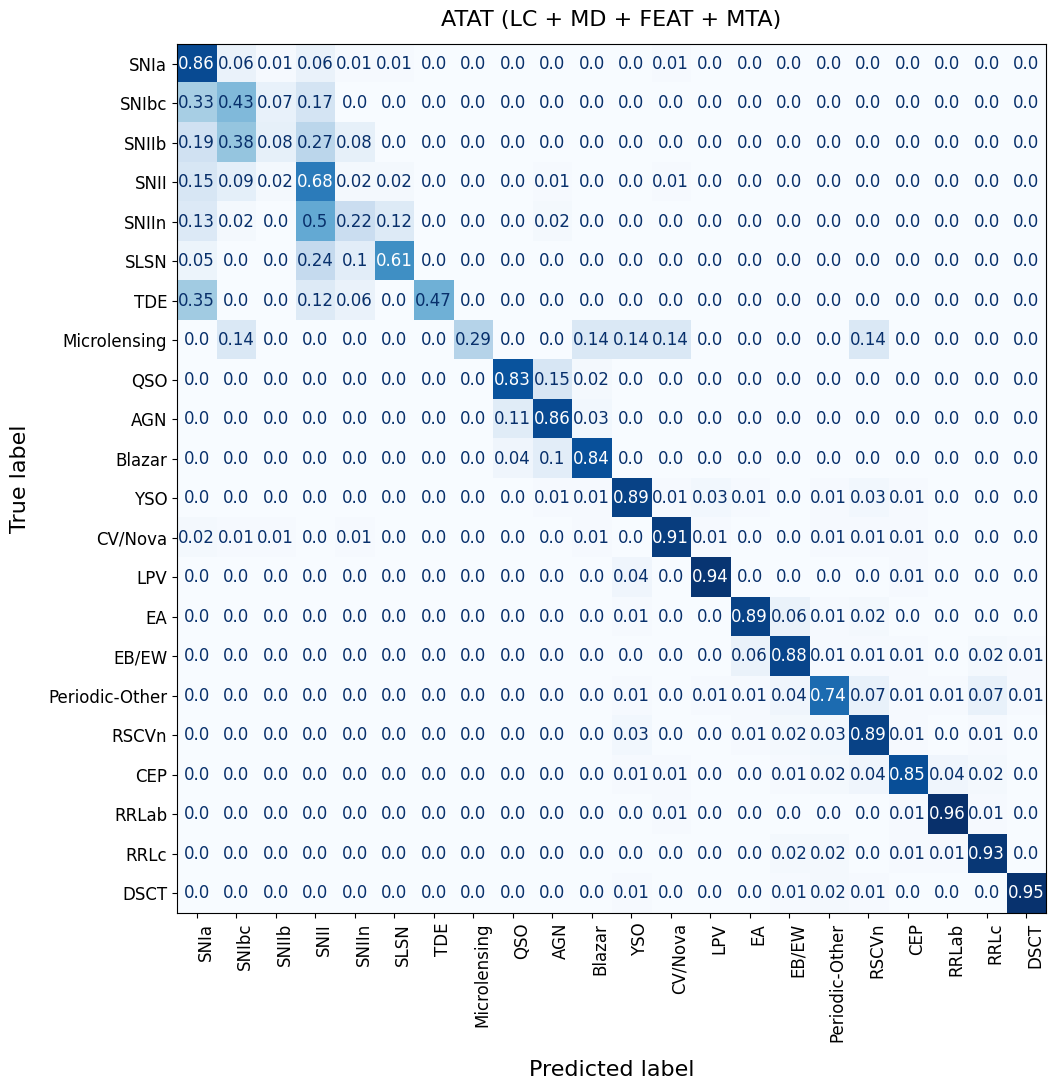

In [43]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

fs = 12

cm = confusion_matrix(y_true=y_real_test, y_pred=y_pred_test, labels=order_classes, normalize='true')

cmap = plt.cm.Blues
fig, ax = plt.subplots(figsize=(11, 11)) #, dpi=110)
im = ax.imshow(np.around(cm, decimals=2), interpolation='nearest', cmap=cmap)

# color map
new_color = cmap(1.0) 

# Añadiendo manualmente las anotaciones con la media y desviación estándar
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if cm[i, j] >= 0.005:
            #print(cm[i, j])
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)
        else:
            text = f'{np.around(cm[i, j], decimals=2)}'
            color = "white" if cm[i, j] > 0.5 else new_color  # Blanco para la diagonal, tono de azul para otras celdas
            ax.text(j, i, text, ha="center", va="center", color=color, fontsize=fs)

# Ajustes finales y mostrar la gráfica
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(np.arange(len(order_classes)))
ax.set_yticks(np.arange(len(order_classes)))
ax.set_xticklabels(order_classes)
ax.set_yticklabels(order_classes)
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

ax.set_title('ATAT (LC + MD + FEAT + MTA)', fontsize=16, pad=13)
ax.set_xlabel('Predicted label', fontsize=16, labelpad=13)  # Label del eje x
ax.set_ylabel('True label', fontsize=16, labelpad=13)        # Label del eje y

ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.xaxis.labelpad = 13
ax.yaxis.labelpad = 13

plt.tight_layout()
plt.show()

In [44]:
from sklearn.metrics import f1_score

f1_score(y_real_test, y_pred_test, average='macro')

0.7383260970671988

In [45]:
from scipy.stats import entropy

Text(0.5, 0, 'entropy')

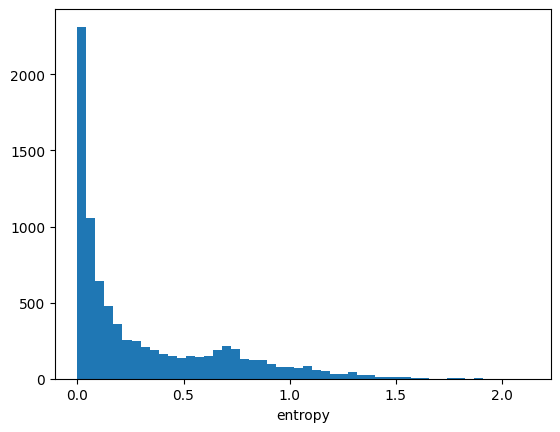

In [46]:
plt.hist(entropy(atat_pred_2048_time_test, axis=1), bins=50);
plt.xlabel('entropy')

Text(0.5, 0, 'highest prob')

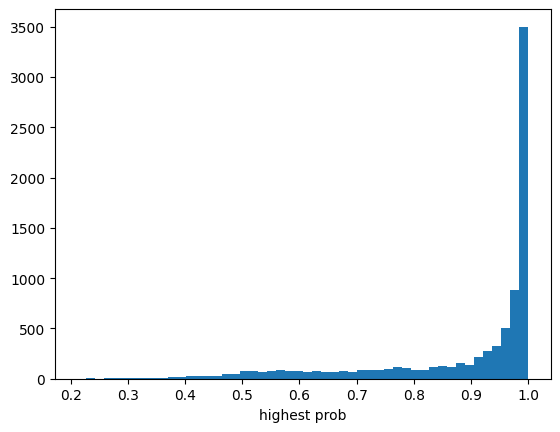

In [47]:
plt.hist(atat_pred_2048_time_test.max(axis=1), bins=50);
plt.xlabel('highest prob')